In [1]:
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

c:\Miniconda\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [2]:
# make dataframe of circles data
import pandas as pd
circles = pd.DataFrame({'X1':X[:,0], 'X2': X[:,1],
                        'label': y
                        })
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [3]:
# how many distinct lables
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

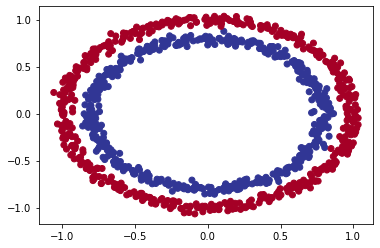

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x=circles.X1, y =circles.X2, c=y, cmap=plt.cm.RdYlBu)

In [5]:
# shape of features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
import torch
X = torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [8]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 out_features means 5 linear units
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x))    
    
model_0 = ClassificationModel()
model_0

ClassificationModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6890,  0.4114],
                      [-0.0360, -0.4173],
                      [-0.2984,  0.0692],
                      [-0.3818,  0.0464],
                      [-0.5807,  0.5359]])),
             ('layer_1.bias',
              tensor([ 0.6620,  0.5093,  0.0505, -0.0956, -0.3528])),
             ('layer_2.weight',
              tensor([[-0.1437,  0.0820, -0.4067,  0.1809,  0.0291]])),
             ('layer_2.bias', tensor([0.0640]))])

In [10]:
model_0 = nn.Sequential(
    nn.Linear (in_features=2, out_features=5),
    nn.Linear (in_features=5, out_features=1)
).to(device)

In [11]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])


In [13]:
loss_fn = nn.BCEWithLogitsLoss() # contains builtin sigmoid
optimizer = torch.optim.SGD(params= model_0.parameters(), lr=0.1)

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/ len(y_pred)) *100
    return acc

In [16]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training loop
for epoch in range(epochs):
    model_0.train() # change mode
    y_logits = model_0(X_train).squeeze() # forward pass
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train) # calculate loss
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_preds) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Test mode
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true= y_test,
                               y_pred= test_preds)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        

Epoch: 0 | Loss: 0.69762, Accuracy: 49.88% | Test loss: 0.69555, Test acc: 50.50%
Epoch: 10 | Loss: 0.69507, Accuracy: 49.88% | Test loss: 0.69347, Test acc: 50.50%
Epoch: 20 | Loss: 0.69417, Accuracy: 41.88% | Test loss: 0.69291, Test acc: 42.00%
Epoch: 30 | Loss: 0.69381, Accuracy: 46.88% | Test loss: 0.69286, Test acc: 48.00%
Epoch: 40 | Loss: 0.69364, Accuracy: 48.75% | Test loss: 0.69297, Test acc: 47.50%
Epoch: 50 | Loss: 0.69352, Accuracy: 48.75% | Test loss: 0.69315, Test acc: 48.50%
Epoch: 60 | Loss: 0.69344, Accuracy: 49.62% | Test loss: 0.69334, Test acc: 48.00%
Epoch: 70 | Loss: 0.69336, Accuracy: 50.00% | Test loss: 0.69353, Test acc: 48.50%
Epoch: 80 | Loss: 0.69329, Accuracy: 49.50% | Test loss: 0.69372, Test acc: 48.00%
Epoch: 90 | Loss: 0.69323, Accuracy: 49.88% | Test loss: 0.69391, Test acc: 47.00%


In [17]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print (f"helper_functions.py already exists, skipping download")
else:
    print ("Downloading helper_functions.py")    
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

In [18]:
from helper_functions import plot_predictions,plot_decision_boundary
     

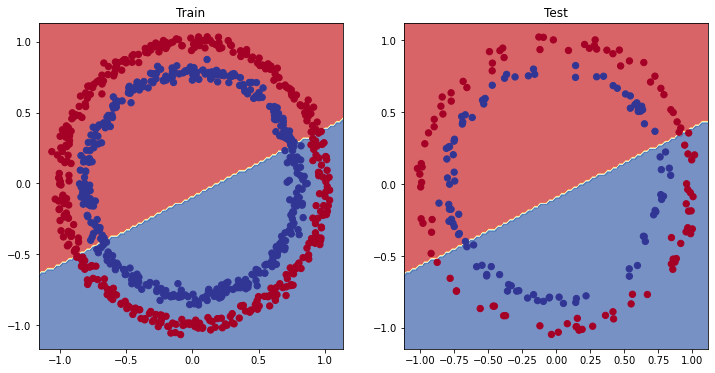

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test,y_test)

In [20]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import torch
from sklearn.model_selection import train_test_split

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

In [22]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            #nn.ReLU()
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1),
            nn.ReLU()
        )
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)
    
model_3 = CircleModelV1()
model_3.to(device)
print(model_3)      

CircleModelV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): ReLU()
  )
)


In [23]:
# The loss functions are stored in nn
# THe loss functions are stored in nn
# THe loss functions are stored in nn
from torch import optim
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_3.parameters(), lr= 0.01)

In [ ]:
torch.manual_seed(42)
epochs = 400

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

## Training
for epoch in range(epochs):
    model_3.train() # train mode
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Evalaution
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(y_logits,y_train)
        
        acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
        
    



In [1]:
!pip -q install torchmetrics

## Building a Multiclass classification Algorithm

In [2]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [8]:
Num_Classes = 4
Num_Feats = 2
Rand_Seed = 42
# Create Dataset
X_blob, y_blob = make_blobs(n_samples=1000,
                            cluster_std=1.5,
                            n_features=Num_Feats,
                            centers = Num_Classes,
                            random_state=Rand_Seed,
                            )


tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


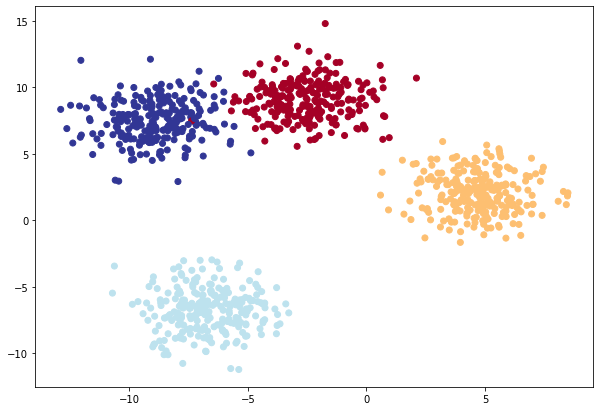

In [9]:
# Create tensors from data
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])
# split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=Rand_Seed
)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0].numpy(),X_blob[:,1].numpy(),
            c= y_blob, cmap = plt.cm.RdYlBu)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [29]:
#X_blob = torch.from_numpy(X_blob).type(torch.float)
#y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
#print(X_blob[:5], y_blob[:5])
Num_Classes = 4
Num_Feats = 2
Rand_Seed = 42
# Create Dataset
X_blob, y_blob = make_blobs(n_samples=1000,
                            cluster_std=1.5,
                            n_features=Num_Feats,
                            centers = Num_Classes,
                            random_state=Rand_Seed,
                            )
# split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=Rand_Seed
)

X_blob_train = torch.from_numpy(X_blob_train).type(torch.float)
X_blob_test = torch.from_numpy(X_blob_test).type(torch.float)
y_blob_train = torch.from_numpy(y_blob_train).type(torch.LongTensor)
y_blob_test = torch.from_numpy(y_blob_test).type(torch.LongTensor)

#plt.figure(figsize=(10,7))
#plt.scatter(X_blob[:,0].numpy(),X_blob[:,1].numpy(),
#            c= y_blob, cmap = plt.cm.RdYlBu)

In [31]:
from torch import nn
class BlobModel (nn.Module):
    def __init__(self, input_features,output_features,hidden_units=8):
        super().__init__()
        
        self.linear_layer_stack= nn.Sequential(
            nn.Linear(in_features=input_features,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_features),
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=Num_Feats, 
                    output_features=Num_Classes, 
                    hidden_units=8).to(device)
model_4    

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr= 0.01)

In [35]:
epochs = 200
from torchmetrics import Accuracy
accuracy_fn= Accuracy().to(device)

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)
for epoch in range(epochs):
    # Training
    model_4.train()
    y_logits = model_4(X_blob_train)
    # argmax is used to get the most probable class
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1) 
    loss = loss_fn(y_logits,y_blob_train)
    acc =  accuracy_fn(y_blob_train,
                      y_preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits,y_blob_test)
        test_acc = accuracy_fn(y_blob_test,
                             test_preds)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")         

Epoch: 0 | Loss: 1.73666, Acc: 0.17% | Test Loss: 1.49801, Test Acc: 0.24%
Epoch: 10 | Loss: 0.63953, Acc: 0.99% | Test Loss: 0.59888, Test Acc: 0.99%
Epoch: 20 | Loss: 0.45326, Acc: 0.98% | Test Loss: 0.43190, Test Acc: 0.99%
Epoch: 30 | Loss: 0.35751, Acc: 0.99% | Test Loss: 0.34402, Test Acc: 0.99%
Epoch: 40 | Loss: 0.29500, Acc: 0.99% | Test Loss: 0.28569, Test Acc: 0.99%
Epoch: 50 | Loss: 0.25068, Acc: 0.99% | Test Loss: 0.24369, Test Acc: 0.99%
Epoch: 60 | Loss: 0.21772, Acc: 0.99% | Test Loss: 0.21201, Test Acc: 0.99%
Epoch: 70 | Loss: 0.19237, Acc: 0.99% | Test Loss: 0.18734, Test Acc: 0.99%
Epoch: 80 | Loss: 0.17235, Acc: 0.99% | Test Loss: 0.16766, Test Acc: 0.99%
Epoch: 90 | Loss: 0.15619, Acc: 0.99% | Test Loss: 0.15165, Test Acc: 0.99%
Epoch: 100 | Loss: 0.14293, Acc: 0.99% | Test Loss: 0.13840, Test Acc: 0.99%
Epoch: 110 | Loss: 0.13187, Acc: 0.99% | Test Loss: 0.12729, Test Acc: 0.99%
Epoch: 120 | Loss: 0.12253, Acc: 0.99% | Test Loss: 0.11786, Test Acc: 0.99%
Epoch: 130

In [36]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_blob_test, y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 0.9950000047683716%


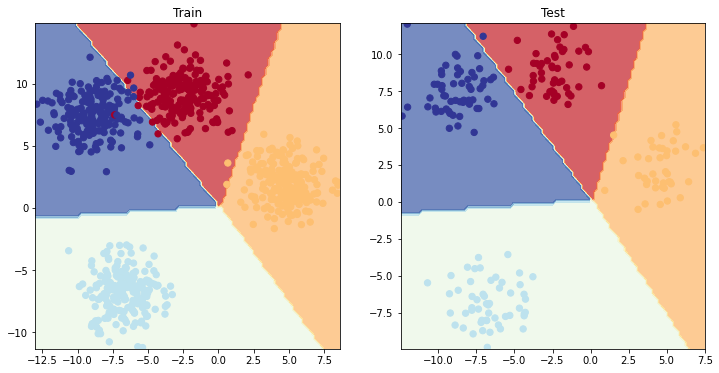

In [37]:
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)